In [1]:
from scipy.sparse import csr_matrix
import numpy as np


def cargar_datos():
        
    #se cargan los txt 
    perfiles = [line.rstrip('\n') for line in open('user_skill')]
    skills = [line.rstrip('\n') for line in open('skill_id')]

    #dimensiones de la matriz
    n = len(perfiles)
    d = len(skills)
        
    filas = np.empty(shape =(1,0))
    columnas = np.empty(shape=(1,0))
    cantidad = 0

    for linea in perfiles:
        persona = int(linea.split(":")[0])
        habilidades = linea.split(":")[1].split(",")
        for j in habilidades:
            filas = np.append(filas, persona)
            columnas = np.append(columnas, int(j))
            cantidad+=1

    datos = csr_matrix((np.ones(cantidad),(filas,columnas)), shape=(n,d))
    
    return n,d,datos




In [2]:
n,d,datos = cargar_datos()

In [89]:
from random import randint
from sklearn.cross_validation import train_test_split

datos_train, datos_test = train_test_split(datos, test_size=0.3, random_state = 5)
print "Datos entrenamiento: ", datos_train.shape
print "Datos prueba: ", datos_test.shape
print "Suma de filas: ", datos_train.shape[0]+datos_test.shape[0]

Datos entrenamiento:  (5523, 14544)
Datos prueba:  (2367, 14544)
Suma de filas:  7890


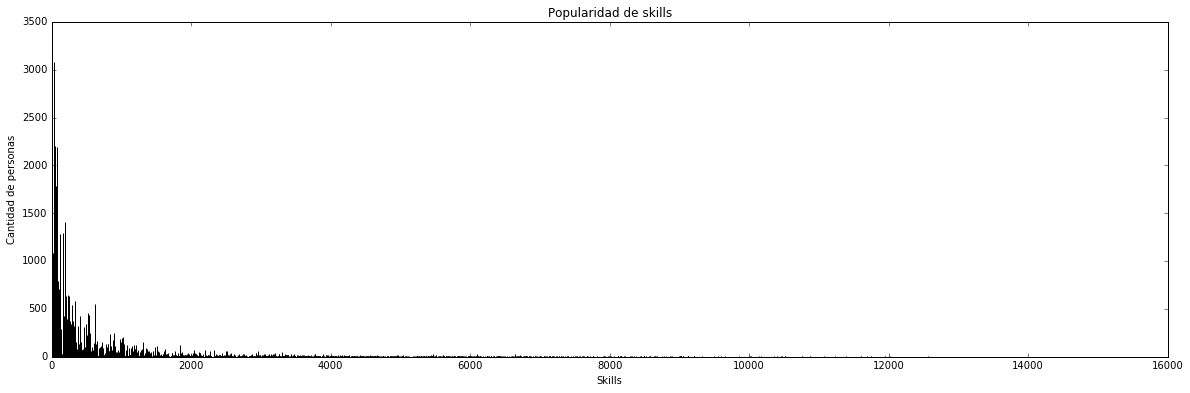

In [38]:
from matplotlib import pyplot as plt
from matplotlib import colors

suma_columnas = datos.sum(axis=0)

fig,ax = plt.subplots(figsize=(20, 6), dpi=300)
index = np.arange(d)
bar_width = 0.05
opacity = 1

plt.bar(index + bar_width, np.asarray(suma_columnas)[0], bar_width,
        alpha=opacity, color='deeppink', label='Accuracy Test')
plt.xlabel('Skills')
plt.ylabel('Cantidad de personas')
plt.title('Popularidad de skills')

fig.savefig('popularidad_skills.png', savefig=500)
plt.show()


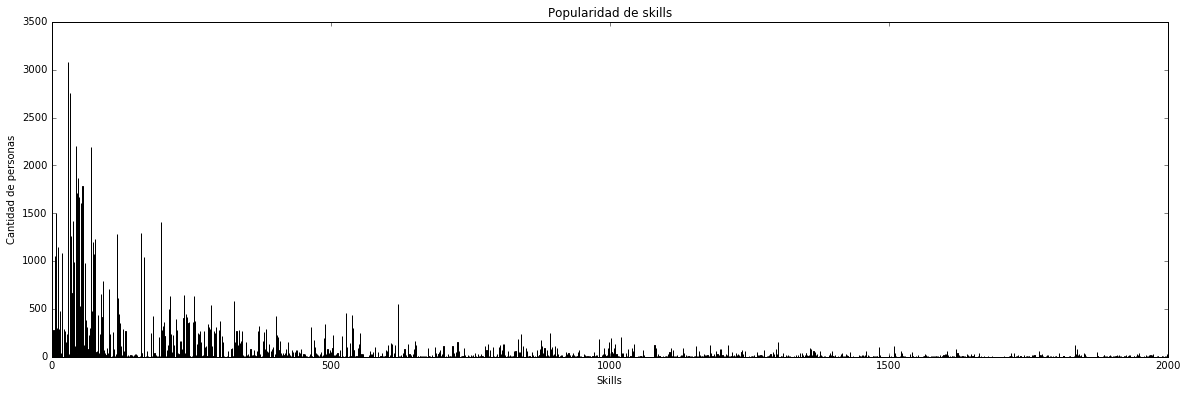

In [6]:
fig,ax = plt.subplots(figsize=(20, 6), dpi=500)
index = np.arange(2000)
bar_width = 0.15
opacity = 1

plt.bar(index + bar_width, np.asarray(suma_columnas)[0][0:2000], bar_width,
        alpha=opacity, color='deeppink', label='Accuracy Test')
plt.xlabel('Skills')
plt.ylabel('Cantidad de personas')
plt.title('Popularidad de skills')

fig.savefig('popularidad_skills_top2000.png', savefig=500)
plt.show()

In [7]:
top_500 = np.copy(np.asarray(suma_columnas)[0][0:500])
top_10 = np.zeros(10)

for i in range(10):
    top_10[i]=np.argmax(top_500)
    top_500[int(top_10[i])] = 0


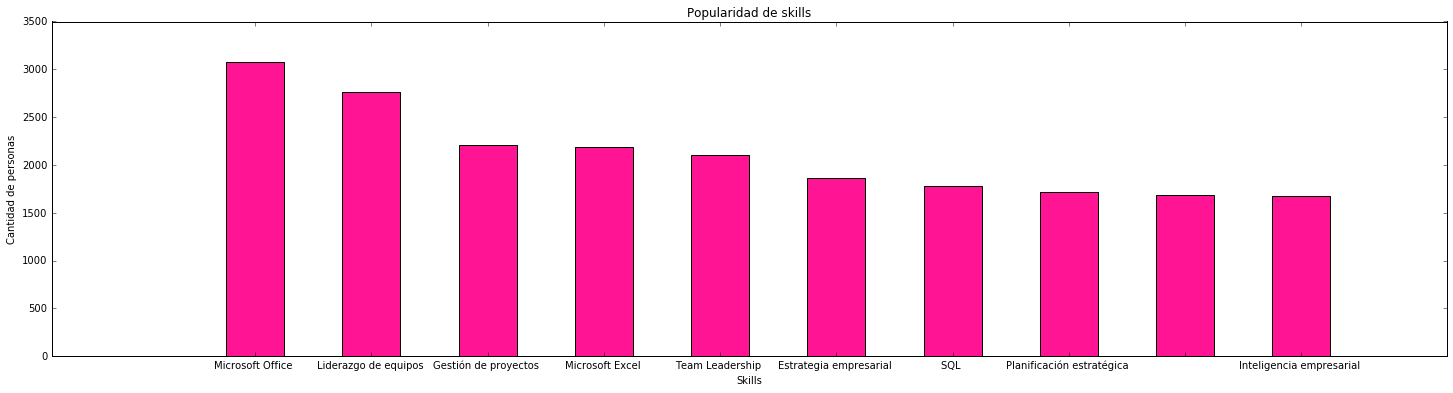

In [35]:
fig,ax = plt.subplots(figsize=(25, 6), dpi=500)
index = np.arange(10)
bar_width = 0.5
opacity = 1


nombres = []
skills = [line.rstrip('\n') for line in open('skill_id')]
for i in top_10:
    nombres.append(skills[int(i)].split(":")[0].decode('utf-8'))

for i in range(10):
    plt.bar(i + bar_width+1, np.asarray(suma_columnas)[0][int(top_10[i])], bar_width,
        alpha=opacity, color='deeppink')


plt.xlabel('Skills')
plt.ylabel('Cantidad de personas')
plt.title('Popularidad de skills')
plt.xticks(np.arange(10) + bar_width*1.5 +1, nombres)


fig.savefig('popularidad_skills_top10.png', savefig=500)
plt.show()

In [119]:
#Elegimos SQL = 55
selector = [x for x in range(datos.shape[1]) if x != 55]
X_train = datos_train[:, selector]
y_train = datos_train.getcol(55).A.T[0]
X_test = datos_test[:, selector]
y_test = datos_test.getcol(55).A.T[0]
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(5523, 14543)
(5523,)
(2367, 14543)
(2367,)


In [156]:
from sklearn.metrics import precision_recall_fscore_support

def score_the_model(model,x,y,xt,yt,text, prnt):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    if prnt:
        print "\tTraining Accuracy %s: %f"%(text,acc_tr)
        print "\tTest Accuracy %s: %f"%(text,acc_test)
    return acc_tr, acc_test

In [157]:
import random
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

acc_train = []
acc_test = []

print "---Usando Bernoulli Naive Bayes:\n"

def do_NAIVE_BAYES(x,y,xt,yt,prnt=True):
    model = BernoulliNB()
    model = model.fit(x, y)
    acc_tr, acc_test = score_the_model(model,x,y,xt,yt,"BernoulliNB", prnt)
    return acc_tr, acc_test

atr, att = do_NAIVE_BAYES(X_train, y_train, X_test, y_test)
acc_train.append(atr)
acc_test.append(att)

print "\n---Usando Multinomial Naive Bayes: \n"

def do_MULTINOMIAL(x,y,xt,yt,prnt=True):
    model = MultinomialNB()
    model = model.fit(x, y)
    acc_tr, acc_test = score_the_model(model,x,y,xt,yt,"MultinomialNB", prnt)
    return acc_tr, acc_test

atr, att = do_MULTINOMIAL(X_train, y_train, X_test, y_test)
acc_train.append(atr)
acc_test.append(att)

print "\n---Usando Regresion Logistica:\n"

def do_LOGIT(x,y,xt,yt,prnt=True):
    '''Cs = [0.01,0.1,10,100,1000]
    for C in Cs:'''
    ''' print "--Usando C= %f"%C'''
    model = LogisticRegression(penalty='l2',C=0.1)
    model = model.fit(x, y)
    acc_tr, acc_test = score_the_model(model,x,y,xt,yt,"LOGISTIC", prnt)
    return acc_tr, acc_test

atr, att = do_LOGIT(X_train, y_train, X_test, y_test)
acc_train.append(atr)
acc_test.append(att)

print "\n---Usando SVM lineal:\n"

def do_SVM(x,y,xt,yt,i=False,prnt=True):
    Cs = [0.01,0.1,10,100,1000]
    if i:
        for C in Cs:
            print "--Usando C= %f"%C
            model = LinearSVC(C=C)
            model = model.fit(x, y)
            acc_tr, acc_test = score_the_model(model,x,y,xt,yt,"SVM", prnt)
    else:
        model = LinearSVC(C=0.01)
        model = model.fit(x, y)
        acc_tr, acc_test = score_the_model(model,x,y,xt,yt,"SVM", prnt)
    return acc_tr, acc_test

atr, att = do_SVM(X_train, y_train, X_test, y_test)
acc_train.append(atr)
acc_test.append(att) 

print "\n---Usando K nearest neighbor:\n"

def do_KNN(x,y,xt,yt,prnt=True):
    model = KNeighborsClassifier()
    model = model.fit(x, y)
    acc_tr, acc_test = score_the_model(model,x,y,xt,yt,"KNN", prnt)
    return acc_tr, acc_test

atr, att = do_KNN(X_train, y_train, X_test, y_test)
acc_train.append(atr)
acc_test.append(att) 

---Usando Bernoulli Naive Bayes:

	Training Accuracy BernoulliNB: 0.943483
	Test Accuracy BernoulliNB: 0.923077

---Usando Multinomial Naive Bayes: 

	Training Accuracy MultinomialNB: 0.937220
	Test Accuracy MultinomialNB: 0.894336

---Usando Regresion Logistica:

	Training Accuracy LOGISTIC: 0.971965
	Test Accuracy LOGISTIC: 0.952663

---Usando SVM lineal:

	Training Accuracy SVM: 0.972711
	Test Accuracy SVM: 0.956044

---Usando K nearest neighbor:

	Training Accuracy KNN: 0.951536
	Test Accuracy KNN: 0.939138


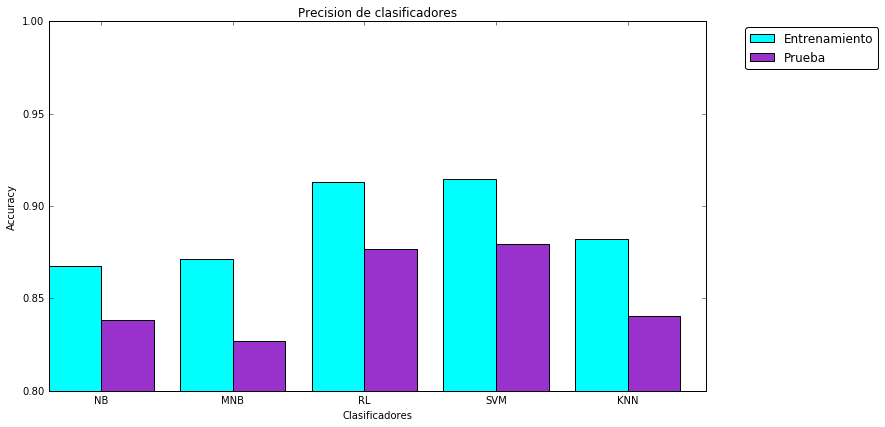

In [153]:
def graficar(acc_train, acc_test):
    
    fig, ax = plt.subplots(figsize=(10,6))
    index = np.arange(5)
    bar_width = 0.4
    opacity = 1

    plt.bar(index, acc_train, bar_width,
                     alpha=opacity,
                     color='aqua',
                     label='Entrenamiento')

    plt.bar(index + bar_width, acc_test, bar_width,
                     alpha=opacity,
                     color='darkorchid',
                     label='Prueba')

    plt.xlabel('Clasificadores')
    plt.ylabel('Accuracy')
    plt.ylim((0.8, 1))
    plt.title('Precision de clasificadores')
    plt.xticks(index + bar_width, ('NB', 'MNB', 'RL', 'SVM', 'KNN'))
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2,fancybox=True)

    plt.tight_layout()
    plt.show()

graficar(acc_train, acc_test)

In [164]:
def graficar_classif(acc_train, acc_test, savename):
    
    fig, ax = plt.subplots(figsize=(5,3))
    index = np.arange(5)
    bar_width = 0.3
    opacity = 1

    plt.bar(index, acc_train, bar_width,
                     alpha=opacity,
                     color='aqua',
                     label='Entrenamiento')

    plt.bar(index + bar_width, acc_test, bar_width,
                     alpha=opacity,
                     color='darkorchid',
                     label='Prueba')

    plt.xlabel('Clasificadores')
    plt.ylabel('Accuracy')
    plt.ylim((0.8, 1))
    plt.title('Precision de clasificadores')
    plt.xticks(index + bar_width, ('NB', 'MNB', 'RL', 'SVM', 'KNN'))
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2,fancybox=True)
    
    fig.savefig(savename)
    
    plt.tight_layout()
    plt.show()




Clasificando 'Telecommunications' para % de entrenamiento = 0.85 




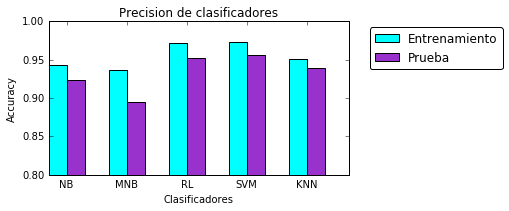



Clasificando 'Team Leadership' para % de entrenamiento = 0.85 




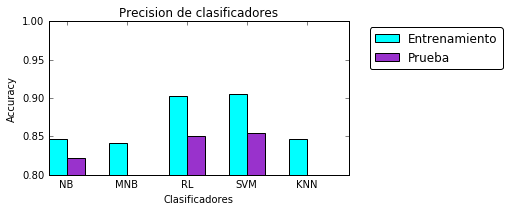



Clasificando 'Planificacion Estrategica' para % de entrenamiento = 0.85 




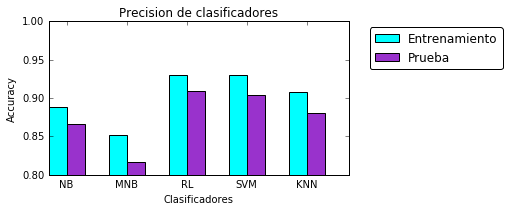



Clasificando 'Telecommunications' para % de entrenamiento = 0.75 




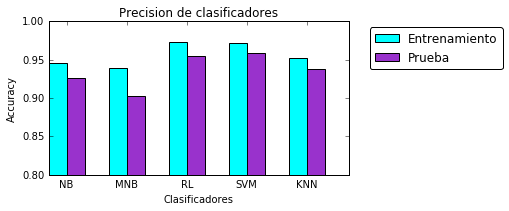



Clasificando 'Team Leadership' para % de entrenamiento = 0.75 




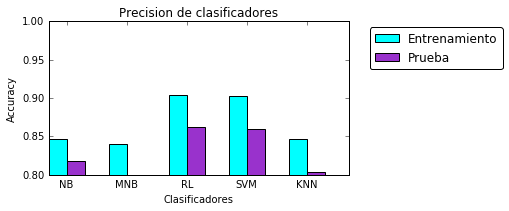



Clasificando 'Planificacion Estrategica' para % de entrenamiento = 0.75 




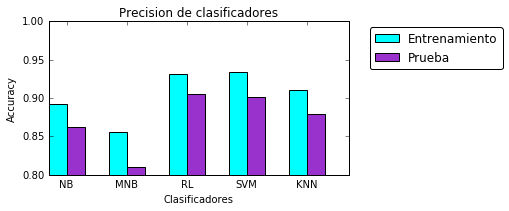



Clasificando 'Telecommunications' para % de entrenamiento = 0.5 




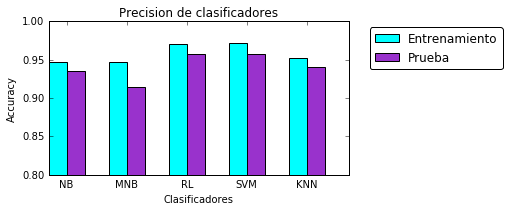



Clasificando 'Team Leadership' para % de entrenamiento = 0.5 




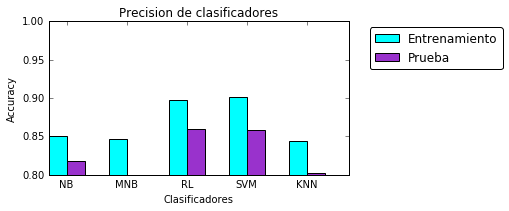



Clasificando 'Planificacion Estrategica' para % de entrenamiento = 0.5 




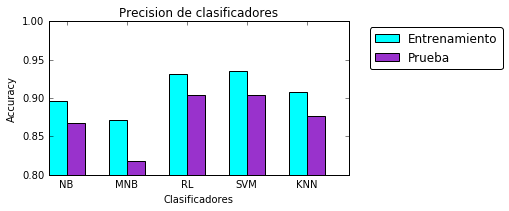

In [167]:
revisar = [15,1,45]
'''
15: Telecommunications
1: Team Leadership
45: Planificacion Estrategica
'''

for j in [0.15, 0.25, 0.5]:
    datos_train, datos_test = train_test_split(datos, test_size=j, random_state = 5)
    for i in revisar:
        if i==15:
            print "\n\nClasificando \'Telecommunications\' para % de entrenamiento =", (1-j), "\n\n"
        elif i==1:
            print "\n\nClasificando \'Team Leadership\' para % de entrenamiento =", (1-j), "\n\n"
        elif i==45:
            print "\n\nClasificando \'Planificacion Estrategica\' para % de entrenamiento =", (1-j), "\n\n"
        acc_test = []
        acc_train = []
        selector = [x for x in range(datos.shape[1]) if x != i]
        X_train = datos_train[:, selector]
        y_train = datos_train.getcol(i).A.T[0]
        X_test = datos_test[:, selector]
        y_test = datos_test.getcol(i).A.T[0]
        
        atr, att = do_NAIVE_BAYES(X_train, y_train, X_test, y_test, prnt=False)
        acc_train.append(atr)
        acc_test.append(att)
        atr, att = do_MULTINOMIAL(X_train, y_train, X_test, y_test, prnt=False)
        acc_train.append(atr)
        acc_test.append(att)
        atr, att = do_LOGIT(X_train, y_train, X_test, y_test, prnt=False)
        acc_train.append(atr)
        acc_test.append(att)
        atr, att = do_SVM(X_train, y_train, X_test, y_test, prnt=False)
        acc_train.append(atr)
        acc_test.append(att) 
        atr, att = do_KNN(X_train, y_train, X_test, y_test, prnt=False)
        acc_train.append(atr)
        acc_test.append(att) 
        graficar_classif(acc_train, acc_test, "skill="+str(i)+" porcentaje test="+str(j)+".png")
        
        

